## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz

%matplotlib inline

<br><br>

### Data and preprocessing <a name="1"></a>
<hr>

Importing the dataset

In [2]:
spotify_df = pd.read_csv("SpotifyFeatures.csv")
spotify_df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


Cleaning up the CSV a bit. In particular, 

1. I'm changing popularity of 0 to 1 to avoid divide by zero errors latter. Note that the popularity ranges from 0 to 100, with 0 being least popular and 100 being most popular. So changing the popularity from 0 to 1 should not make a huge difference.
2. Seems like the genre feature has two slightly different versions of the category Children's Music with two different quotation marks (` and '). I'm mapping them both to "Children's Music".  

In [3]:
spotify_df.loc[spotify_df["popularity"] == 0, "popularity"] = 1

In [4]:
spotify_df["genre"].value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

In [5]:
spotify_df.loc[spotify_df["genre"] == "Children’s Music", "genre"] = "Children's Music"

This dataset is large and in this lab we want to explore ensemble methods which can be computationally intensive. So when we split the data, I am putting most of the data in the test split. If your computer can handle it, you are welcome to experiment with a bigger training split. 

In [6]:
spotify_df.shape

(232725, 18)

In [7]:
train_df, test_df = train_test_split(spotify_df, test_size=0.97, random_state=123)

In [8]:
train_df.shape

(6981, 18)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6981 entries, 57856 to 15725
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre             6981 non-null   object 
 1   artist_name       6981 non-null   object 
 2   track_name        6981 non-null   object 
 3   track_id          6981 non-null   object 
 4   popularity        6981 non-null   int64  
 5   acousticness      6981 non-null   float64
 6   danceability      6981 non-null   float64
 7   duration_ms       6981 non-null   int64  
 8   energy            6981 non-null   float64
 9   instrumentalness  6981 non-null   float64
 10  key               6981 non-null   object 
 11  liveness          6981 non-null   float64
 12  loudness          6981 non-null   float64
 13  mode              6981 non-null   object 
 14  speechiness       6981 non-null   float64
 15  tempo             6981 non-null   float64
 16  time_signature    6981 non-null   obj

I am defining different feature types and a couple of preprocessors below.  

In [10]:
drop_features = ["track_id", "artist_name"]
binary_features = ["mode"]
categorical_features = ["genre", "time_signature", "key"]
text_feature = "track_name"
target = "popularity"
numeric_features = list(
    set(train_df.columns)
    - set(drop_features)
    - set([text_feature])
    - set(binary_features)
    - set(categorical_features)
    - set([target])
)
assert train_df.columns.shape[0] == len(
    drop_features
    + binary_features
    + categorical_features
    + numeric_features
    + [text_feature]
    + [target]
)

Defining the required preprocessor.

In [11]:
preprocessor_all = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_features),
    (OneHotEncoder(handle_unknown="ignore", dtype="int"), categorical_features),
    (CountVectorizer(stop_words="english", max_features=100), text_feature),
    ("drop", drop_features),
)  # preprocessor which includes all features

In [12]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

In [13]:
preprocessor_all.fit(X_train);

OK. Seems like the preprocessors are working OK. 

### EDA


1) Are the features danceability and energy correlated?

2) Which possible numeric features are more correlated to feature popularity?


In [14]:

possibly_most_relevant = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "tempo", 
    "popularity",
]
cor = train_df[possibly_most_relevant].corr()
cor

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,popularity
acousticness,1.000000,-0.357658,-0.725823,0.325105,0.062738,-0.685641,0.146280,-0.235088,-0.382900
danceability,-0.357658,1.000000,0.317064,-0.375560,-0.051150,0.433079,0.150332,0.038445,0.245030
energy,-0.725823,0.317064,1.000000,-0.392617,0.197124,0.814222,0.148422,0.229056,0.254626
instrumentalness,0.325105,-0.375560,-0.392617,1.000000,-0.135068,-0.516023,-0.179504,-0.118903,-0.212365
liveness,0.062738,-0.051150,0.197124,-0.135068,1.000000,0.048318,0.498724,-0.042219,-0.151185
loudness,-0.685641,0.433079,0.814222,-0.516023,0.048318,1.000000,0.009731,0.234704,0.363156
speechiness,0.146280,0.150332,0.148422,-0.179504,0.498724,0.009731,1.000000,-0.070959,-0.137286
tempo,-0.235088,0.038445,0.229056,-0.118903,-0.042219,0.234704,-0.070959,1.000000,0.094807
popularity,-0.382900,0.245030,0.254626,-0.212365,-0.151185,0.363156,-0.137286,0.094807,1.000000


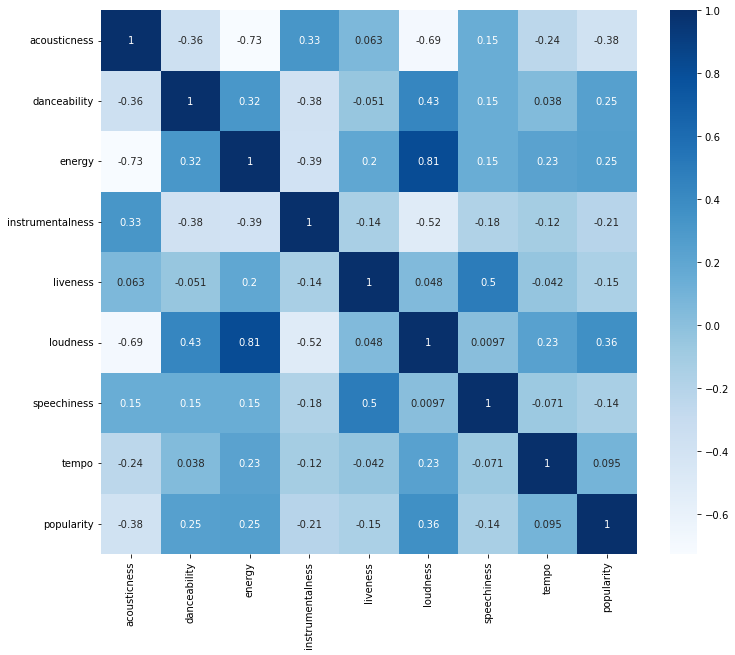

In [15]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

<br><br><br><br>

1) Danceability and energy are positively correlated, as seen in the graph above. 

2) The feature acousticness and loudness have higher correlation to popularity compared to other features .
   Acousticness is negatively correlated to the feature popularity while loudness is positively correlated to the feature   popularity.

## Ensembles <a name="2"></a>
<hr>


### Baseline - Dummy regressor

In [16]:
from sklearn.metrics import make_scorer


def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true)) # defining the mape scoring metric


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

scoring_metrics = {
    "neg RMSE": "neg_root_mean_squared_error",
    "r2": "r2",
    "mape": mape_scorer,
}

In [17]:
results = {}

In [18]:
# Defining the cross - validation function.

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [19]:
# Checking the baseline model
dummy = DummyRegressor()
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results).T

,fit_time,score_time,test_neg RMSE,train_neg RMSE,test_r2,train_r2,test_mape,train_mape
Dummy,0.001 (+/- 0.000),0.001 (+/- 0.000),-18.105 (+/- 0.329),-18.102 (+/- 0.083),-0.002 (+/- 0.001),0.000 (+/- 0.000),-193.549 (+/- 16.812),-193.505 (+/- 3.874)


Here the mean cross validation score with standard deviation is 0.002 (+/- 0.001).

## Tree-based models and Linear model <a name="3"></a>
<hr>

In [20]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor

pipe_ridge_all = make_pipeline(
    preprocessor_all, Ridge(max_iter = 2000, random_state=123)
)
pipe_rf_all = make_pipeline(preprocessor_all, RandomForestRegressor(random_state=123))
pipe_xgb_all = make_pipeline(
    preprocessor_all, XGBRegressor(random_state=123, eval_metric = "logloss", verbosity=0)
)
pipe_lgbm_all= make_pipeline(preprocessor_all, LGBMRegressor(random_state=123))
pipe_catboost_all = make_pipeline(
    preprocessor_all, CatBoostRegressor(random_state=123, verbose = 0)
)
models = {
    "ridge": pipe_ridge_all,
    "random forest": pipe_rf_all,
    "XGBoost": pipe_xgb_all,
    "LightGBM": pipe_lgbm_all,
    "CatBoost": pipe_catboost_all,
}

In [21]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )
pd.DataFrame(results).T

,fit_time,score_time,test_neg RMSE,train_neg RMSE,test_r2,train_r2,test_mape,train_mape
Dummy,0.001 (+/- 0.000),0.001 (+/- 0.000),-18.105 (+/- 0.329),-18.102 (+/- 0.083),-0.002 (+/- 0.001),0.000 (+/- 0.000),-193.549 (+/- 16.812),-193.505 (+/- 3.874)
ridge,0.060 (+/- 0.002),0.011 (+/- 0.000),-11.086 (+/- 0.236),-10.788 (+/- 0.057),0.624 (+/- 0.011),0.645 (+/- 0.003),-108.498 (+/- 12.843),-104.685 (+/- 1.948)
random forest,14.260 (+/- 0.093),0.037 (+/- 0.000),-10.611 (+/- 0.408),-3.910 (+/- 0.039),0.656 (+/- 0.023),0.953 (+/- 0.001),-87.584 (+/- 12.946),-31.162 (+/- 1.032)
XGBoost,0.462 (+/- 0.022),0.017 (+/- 0.002),-10.676 (+/- 0.324),-5.235 (+/- 0.125),0.652 (+/- 0.017),0.916 (+/- 0.004),-86.659 (+/- 11.457),-31.978 (+/- 1.879)
LightGBM,0.170 (+/- 0.022),0.015 (+/- 0.000),-10.408 (+/- 0.387),-7.799 (+/- 0.057),0.669 (+/- 0.019),0.814 (+/- 0.003),-85.653 (+/- 13.173),-58.430 (+/- 2.117)
CatBoost,1.932 (+/- 0.048),0.014 (+/- 0.001),-10.172 (+/- 0.268),-7.084 (+/- 0.053),0.684 (+/- 0.013),0.847 (+/- 0.001),-82.484 (+/- 9.400),-49.896 (+/- 1.391)


##### Best and the worst performing models:

CatBoost is the best performing model in the given scenario since, as seen above, it has a good $R2$ and the difference between the train and the test $R2$ is quite small compared to the other models. CatBoost has the lowest mape score as well. 

Ridge is the worst performing model in the given scenario, as shown above, since it has the lowest train and test $R2$. It has the lowest mape score as well.

##### Overfitting/Underfitting:

In comparison to the other models, the Random forest and XGBoost models appear to be overfitted, since the difference between the train and the test $R2$ is rather large. Also, because both models are tree-based and the control hyperparameter isn't set, the model overfits the train data. 

In the current case, the Ridge model is underfitting since it has the lowest train and test $R2$, as well as a smaller gap between the train and the test $R2$ than the other models. Ridge is a linear model, hence it works best with data that has a linear pattern.

##### Fit time:

The Random Forest has the longest fit time since it takes time to fit the default amount of trees, which is 100. Ridge is the fastest with the quickest fit time.

##### Score time:

Random forest has the highest score time since it individually scores the trees and then cumulates them in the end.
The Ridge has the lowest score time since the coefficients are already calculated and its a simple model. 

### Voting regressor 

In [22]:
from sklearn.ensemble import VotingRegressor

averaging_model = VotingRegressor(
    list(models.items()),n_jobs=-1
)

In [23]:
results["Voting"] = mean_std_cross_val_scores(averaging_model, 
                                              X_train, y_train, 
                                              return_train_score=True, 
                                              scoring=scoring_metrics)
pd.DataFrame(results).T

,fit_time,score_time,test_neg RMSE,train_neg RMSE,test_r2,train_r2,test_mape,train_mape
Dummy,0.001 (+/- 0.000),0.001 (+/- 0.000),-18.105 (+/- 0.329),-18.102 (+/- 0.083),-0.002 (+/- 0.001),0.000 (+/- 0.000),-193.549 (+/- 16.812),-193.505 (+/- 3.874)
ridge,0.060 (+/- 0.002),0.011 (+/- 0.000),-11.086 (+/- 0.236),-10.788 (+/- 0.057),0.624 (+/- 0.011),0.645 (+/- 0.003),-108.498 (+/- 12.843),-104.685 (+/- 1.948)
random forest,14.260 (+/- 0.093),0.037 (+/- 0.000),-10.611 (+/- 0.408),-3.910 (+/- 0.039),0.656 (+/- 0.023),0.953 (+/- 0.001),-87.584 (+/- 12.946),-31.162 (+/- 1.032)
XGBoost,0.462 (+/- 0.022),0.017 (+/- 0.002),-10.676 (+/- 0.324),-5.235 (+/- 0.125),0.652 (+/- 0.017),0.916 (+/- 0.004),-86.659 (+/- 11.457),-31.978 (+/- 1.879)
LightGBM,0.170 (+/- 0.022),0.015 (+/- 0.000),-10.408 (+/- 0.387),-7.799 (+/- 0.057),0.669 (+/- 0.019),0.814 (+/- 0.003),-85.653 (+/- 13.173),-58.430 (+/- 2.117)
CatBoost,1.932 (+/- 0.048),0.014 (+/- 0.001),-10.172 (+/- 0.268),-7.084 (+/- 0.053),0.684 (+/- 0.013),0.847 (+/- 0.001),-82.484 (+/- 9.400),-49.896 (+/- 1.391)
Voting,14.593 (+/- 0.403),0.089 (+/- 0.003),-10.205 (+/- 0.333),-6.621 (+/- 0.052),0.682 (+/- 0.016),0.866 (+/- 0.002),-88.561 (+/- 11.262),-54.004 (+/- 1.327)


1) 5 Models are being averaged here.We are getting a better cross val scores i.e. test $R^2$ compared to the individual models .i.e. 0.334 for the Voting regressor.

2) Voting regressor averages several regression models and it averages the individual model predictions to form a final prediction.

   In Regression Voting, predictions are the average of contributing models it is different from Classification Voting because predictions are the majority vote of contributing models in classification voting problem.In case of voting classifier there are also two types of voting hard(predict) and soft(predict_proba).

### Stacking regressor 

In [24]:
from sklearn.ensemble import StackingRegressor 
stacking_model = StackingRegressor(list(models.items()), final_estimator=Ridge())



In [25]:
results["Stacking"] = mean_std_cross_val_scores(stacking_model, 
                                              X_train, y_train, 
                                              return_train_score=True, 
                                              scoring=scoring_metrics)
pd.DataFrame(results).T

,fit_time,score_time,test_neg RMSE,train_neg RMSE,test_r2,train_r2,test_mape,train_mape
Dummy,0.001 (+/- 0.000),0.001 (+/- 0.000),-18.105 (+/- 0.329),-18.102 (+/- 0.083),-0.002 (+/- 0.001),0.000 (+/- 0.000),-193.549 (+/- 16.812),-193.505 (+/- 3.874)
ridge,0.060 (+/- 0.002),0.011 (+/- 0.000),-11.086 (+/- 0.236),-10.788 (+/- 0.057),0.624 (+/- 0.011),0.645 (+/- 0.003),-108.498 (+/- 12.843),-104.685 (+/- 1.948)
random forest,14.260 (+/- 0.093),0.037 (+/- 0.000),-10.611 (+/- 0.408),-3.910 (+/- 0.039),0.656 (+/- 0.023),0.953 (+/- 0.001),-87.584 (+/- 12.946),-31.162 (+/- 1.032)
XGBoost,0.462 (+/- 0.022),0.017 (+/- 0.002),-10.676 (+/- 0.324),-5.235 (+/- 0.125),0.652 (+/- 0.017),0.916 (+/- 0.004),-86.659 (+/- 11.457),-31.978 (+/- 1.879)
LightGBM,0.170 (+/- 0.022),0.015 (+/- 0.000),-10.408 (+/- 0.387),-7.799 (+/- 0.057),0.669 (+/- 0.019),0.814 (+/- 0.003),-85.653 (+/- 13.173),-58.430 (+/- 2.117)
CatBoost,1.932 (+/- 0.048),0.014 (+/- 0.001),-10.172 (+/- 0.268),-7.084 (+/- 0.053),0.684 (+/- 0.013),0.847 (+/- 0.001),-82.484 (+/- 9.400),-49.896 (+/- 1.391)
Voting,14.593 (+/- 0.403),0.089 (+/- 0.003),-10.205 (+/- 0.333),-6.621 (+/- 0.052),0.682 (+/- 0.016),0.866 (+/- 0.002),-88.561 (+/- 11.262),-54.004 (+/- 1.327)
Stacking,1164.950 (+/- 1051.385),0.087 (+/- 0.001),-10.155 (+/- 0.299),-6.790 (+/- 0.201),0.685 (+/- 0.015),0.859 (+/- 0.009),-84.573 (+/- 10.896),-51.416 (+/- 1.121)


1) Fit time: The stacking regressor has a long fit time because it requires time to fit each individual model and then fits the final model with each individual model, and the final model calculates coefficients for each individual model. 

   Scoring time: The stacking regressor has a short score time relative to the fit time since it already has the computed coefficients for each model.



### Examine coefficients

In [26]:
stacking_model.fit(X_train, y_train)
pd.DataFrame(
    data=stacking_model.final_estimator_.coef_.flatten(),
    index=models.keys(),
    columns=["Coefficient"],
).sort_values("Coefficient", ascending=False)

,Coefficient
CatBoost,0.692786
ridge,0.123001
XGBoost,0.076497
random forest,0.066991
LightGBM,0.065203


1) The CatBoost has the highest coefficient, implying that the Random Forest's predictions are given more weight and are more trusted than those of other models. 

### Visualize your stacking model as a tree

In [27]:
stacking_model_tree = StackingRegressor(
    list(models.items()), final_estimator=DecisionTreeRegressor(max_depth=3)
)

stacking_model_tree.fit(X_train, y_train);

In [28]:
from sklearn import tree
tree_model = stacking_model_tree.final_estimator_
feature_names = list(stacking_model_tree.named_estimators_.keys())

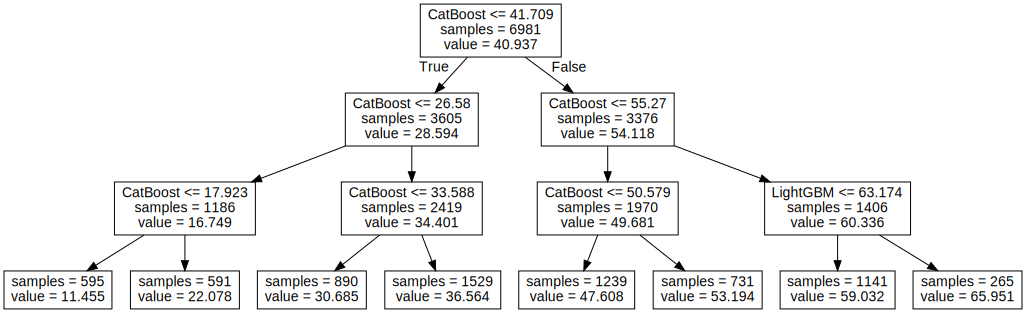

In [29]:
import graphviz
dot = export_graphviz(
        tree_model,
        out_file=None,
        feature_names=feature_names,
        impurity=False,
    )
graph = graphviz.Source(dot)
graph

### True popularity vs predictions  

Best performing regressor is cat boost


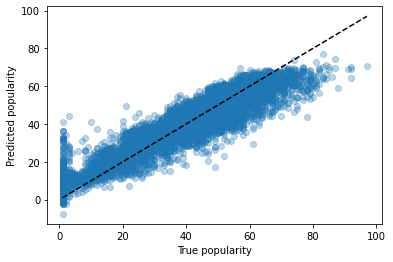

In [30]:
pipe_catboost_all.fit(X_train, y_train)
plt.scatter(y_train, pipe_catboost_all.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("True popularity")
plt.ylabel("Predicted popularity");

By looking at the plot above:
Cat boost model is underestimating for samples with higher true popularity since the points are more under the line.
And is over estimating for samples with very low true popularity since the points are over the line. 
We can also see that some predictions are way off.

<br><br>

### Ridge coefficients

In [31]:
pipe_ridge_all.fit(X_train, y_train)

standard_scalar_names= pipe_ridge_all.named_steps['columntransformer'].named_transformers_['standardscaler'].get_feature_names_out().tolist()
onehot1_names= pipe_ridge_all.named_steps['columntransformer'].named_transformers_['onehotencoder-1'].get_feature_names_out().tolist()
onehot2_names= pipe_ridge_all.named_steps['columntransformer'].named_transformers_['onehotencoder-2'].get_feature_names_out().tolist()
countvect_names = pipe_ridge_all.named_steps['columntransformer'].named_transformers_['countvectorizer'].get_feature_names_out().tolist()
feature_names = standard_scalar_names + onehot1_names+ onehot2_names+ countvect_names


{'feature names': feature_names, 
                   'coefficient' :list(pipe_ridge_all[1].coef_), 
                   'magnitude' : np.absolute(list(pipe_ridge_all[1].coef_))
                  }
df_ridge = pd.DataFrame({'feature names': feature_names, 
                   'coefficient' :list(pipe_ridge_all[1].coef_), 
                   'magnitude' : np.absolute(list(pipe_ridge_all[1].coef_))
                  })
df_ridge.sort_values('magnitude', ascending=False)[0:10]

,feature names,coefficient,magnitude
25,genre_Movie,-25.860578,25.860578
27,genre_Pop,24.488320,24.488320
11,genre_A Capella,-23.786705,23.786705
26,genre_Opera,-22.140184,22.140184
29,genre_Rap,19.603970,19.603970
22,genre_Hip-Hop,18.411513,18.411513
32,genre_Rock,17.643129,17.643129
13,genre_Anime,-16.606424,16.606424
19,genre_Dance,15.162345,15.162345
23,genre_Indie,13.052778,13.052778


<br><br>

### Random forest feature importances

In [32]:
pipe_rf_all.fit(X_train, y_train)

Feature_imp = pd.DataFrame(
    data=(pipe_rf_all.named_steps['randomforestregressor'].feature_importances_.flatten()),
    index= feature_names,
    columns=["Feature Importance"],
).sort_values("Feature Importance", ascending=False)
Feature_imp

,Feature Importance
acousticness,0.190679
genre_Movie,0.065080
genre_Pop,0.050674
duration_ms,0.043373
loudness,0.039481
...,...
acoustic,0.000037
city,0.000032
theme,0.000030
spotify,0.000019


The numeric feature acoustiness is driving the predictions the most.We can't say which way the predictions are being driven because the feature importance values don't have a sign associated with them. As a result, we can't say if raising the feature value by a certain amount would enhance or reduce the prediction value.

## SHAP <a name="4"></a>
<hr>

We'll use [SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/) to explain predictions made by our lgbm model with all features.


In [33]:
import shap

Let's first create encoded versions of `X_train` and `X_test` which we need to pass to SHAP.  

In [34]:
preprocessor_all.fit(X_train, y_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['speechiness', 'valence', 'acousticness',
                                  'liveness', 'tempo', 'danceability',
                                  'instrumentalness', 'energy', 'loudness',
                                  'duration_ms']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop='if_binary', dtype='int'),
                                 ['mode']),
                                ('onehotencoder-2',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['genre', 'time_signature', 'key']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'tr

In [35]:
X_train_enc = pd.DataFrame(
    data=preprocessor_all.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,speechiness,valence,acousticness,liveness,tempo,danceability,instrumentalness,energy,loudness,duration_ms,...,talk,theme,time,tu,version,want,way,woman,world,young
57856,-0.459564,-1.489401,1.728729,0.763331,-1.088157,-1.880782,0.019905,-1.300481,-0.490339,1.915608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199801,-0.454588,-1.617463,0.757986,-0.418076,-1.050155,-2.044577,2.535196,-1.319524,-1.429502,-0.107807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85259,-0.277668,0.367119,-0.922102,0.666578,-0.059624,0.074193,-0.488400,0.885676,0.741946,-0.057213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181482,-0.021687,1.502909,-0.586985,-0.617693,0.172648,0.623699,-0.488373,1.201792,0.376336,-0.029608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220736,-0.428050,-1.104071,0.805820,-0.265308,0.330176,-1.315424,-0.488400,0.295337,0.589789,1.271067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's create encoded test data.  

In [36]:
X_test_enc = pd.DataFrame(
    data=preprocessor_all.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

,speechiness,valence,acousticness,liveness,tempo,danceability,instrumentalness,energy,loudness,duration_ms,...,talk,theme,time,tu,version,want,way,woman,world,young
116505,0.011486,0.168928,-0.707976,-0.775554,1.162373,1.152071,-0.488400,0.101097,0.563734,-0.418542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147921,-0.195842,0.058398,-1.011298,-0.504645,-0.672721,0.016072,0.947972,0.596219,0.316876,-0.771418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229940,-0.470621,1.003619,-0.785917,0.233735,0.132193,1.041113,-0.486905,0.737139,0.827628,-0.313561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107239,-0.316922,-1.115505,1.734357,-0.717502,0.699410,-0.787053,-0.488145,-1.809314,-1.770727,0.165647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102112,-0.487760,-0.642895,-0.333747,-0.351877,0.193473,-0.126588,-0.488294,0.139183,0.629707,-0.151975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
pipe_lgbm_all.fit(X_train, y_train);

In [38]:
lgbm_explainer = shap.TreeExplainer(pipe_lgbm_all.named_steps["lgbmregressor"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

In [39]:
# We are only extracting shapely values for the first 100 test examples for speed.
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc[:100])

1) In the above code we pre-process the train data and only transform the test data and then we fit the lgbm model on the train data. The Tree explainer is fitted on the lgbm model in order to apply shap on our model and finally extract the shap values for both test and train data.

2) The shape of SHAP values created for the train data : (6981, 153)
   The shape of SHAP values created for the test data : (100, 153)

In [40]:
train_lgbm_shap_values.shape

(6981, 153)

In [41]:
test_lgbm_shap_values.shape

(100, 153)

<br><br>

### SHAP summary plots

#### Summary plots

In [42]:
shap.initjs()

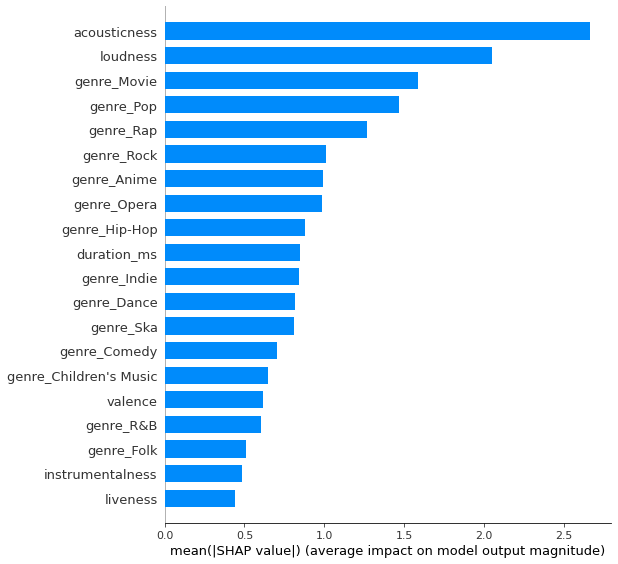

In [43]:
shap.summary_plot(train_lgbm_shap_values, X_train_enc, plot_type="bar")

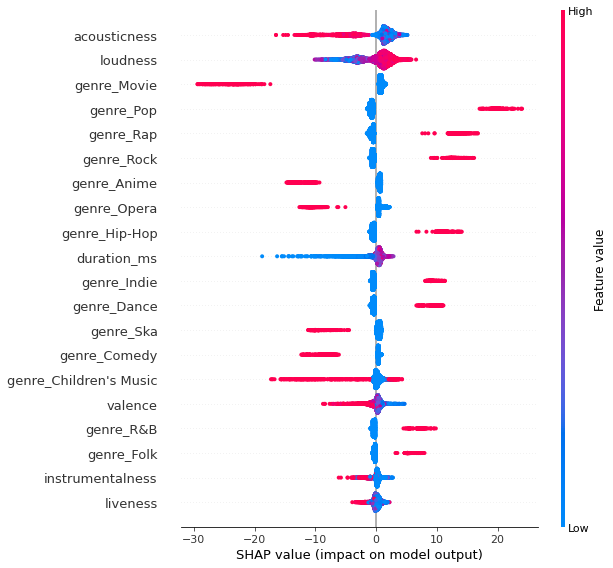

In [44]:
shap.summary_plot(train_lgbm_shap_values, X_train_enc)

1) The first plot shows us the magnitude of impact i.e.feature importance for each feature. The higher the value the given feature has more impact on the prediction value compared to other features.From the plot we can infer acoustiness has the highest impact on the prediction values.And liveliness has the lowest impact. Loudness and presence of genre_movie and genre_pop also have significant impact on the prediction value.

2) The second plot shows the most important features that's driving the predictions. It also shows the direction of how it's going to drive the prediction. As seen form the plot higher values of acoustiness drive the shap value in the negative direction which means the prediction will be driven to a lower value for  higher values of acoustiness. In case of loudness its the inverse. In presence of genre movie the shap values are driven in a negative direction i.e. the prediction will be driven to a lower value in presence of the genre movie,whereas it's absence will have a very low impact.



<br><br>

### SHAP force plots

For better display of the force plot, let's round off feature values. 

In [45]:
X_train_enc = X_train_enc.round(3)
X_test_enc = X_test_enc.round(3)

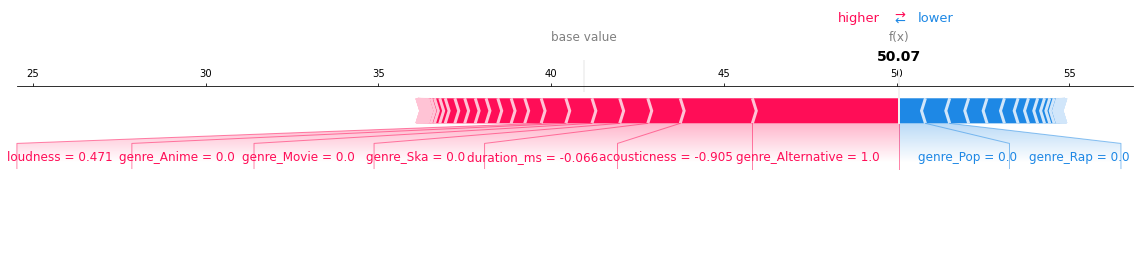

In [46]:
shap.force_plot(
    lgbm_explainer.expected_value,
    test_lgbm_shap_values[8],
    X_test_enc.iloc[8, :],
    matplotlib=True,
)

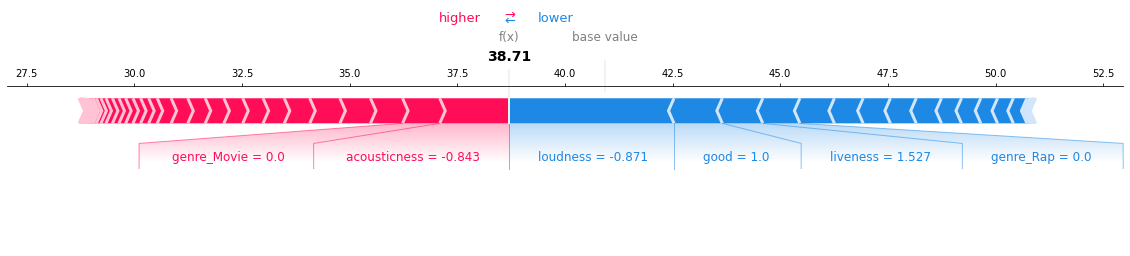

In [47]:
shap.force_plot(
    lgbm_explainer.expected_value,
    test_lgbm_shap_values[6],
    X_test_enc.iloc[6, :],
    matplotlib=True,
)

In [48]:
y_test[6:9]

177086    41
152479    68
12532     50
Name: popularity, dtype: int64

1) The above plot shows the features driving the prediction value to given score  and the overall and the base prediction value for a particular example. Features that push the prediction to a higher value are shown in red.Features that push the prediction to a lower value are shown in blue. The base value here is around 41.

2) The prediction in the first case is 50.7 which is greater than the base value. The presence of feature genre_alternative is driving the prediction in the positive direction and has a major impact. Also lower value of acousticness is driving the prediction in the positive direction.While absence of genre_pop and genre_rap are driving the prediction to a lower value.

   The prediction in the second case is 38.71 which is lower than the base value.The feature loudness has a major impact,the lower value of loudness are driving the prediction in negative direction.The presence of feature good and absence of feature genre_rap are driving the prediction in negative direction. Also lower value of acousticness and presence of genre_movie are driving the prediction in the positive direction.The higher value of feature liveness is driving the prediction to a lower value.

3) The true popularity is close to the prediction.
   In the first case the True popularity is 50 while the predicted popularity is 50.07 which are very close.
   In the second case the True popularity is 41 while the predicted popularity is 38.71 which are close.



<br><br>